In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array



In [14]:
# Définition de la taille des images d'entrée du modèle (128x128 pixels)
image_size = (128, 128)
batch_size = 32
epochs = 50

# Définition du répertoire des données d'entraînement
train_dir = "Players_merged1"


# Initialisation du générateur d'images avec des transformations (augmentation)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Générateur d'images d'entraînement
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# # Générateur d'images de validation
# validation_generator = datagen.flow_from_directory(
#     val_dir,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False
# )


Found 1119 images belonging to 461 classes.


In [15]:
# Charger MobileNetV2 comme modèle de base
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Construction du modèle complet
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])




Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - accuracy: 0.0042 - loss: 6.3464
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.0040 - loss: 6.1242
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.0027 - loss: 6.0943
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.0087 - loss: 6.0510
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 286ms/step - accuracy: 0.0104 - loss: 5.9452
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 346ms/step - accuracy: 0.0237 - loss: 5.8177
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.0154 - loss: 5.7624
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.0341 - loss: 5.5677
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.0467 - loss: 5.4096
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.0597 - loss: 5.3003
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - accuracy: 0.0808 - loss: 5.0750
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms

KeyError: 'val_accuracy'

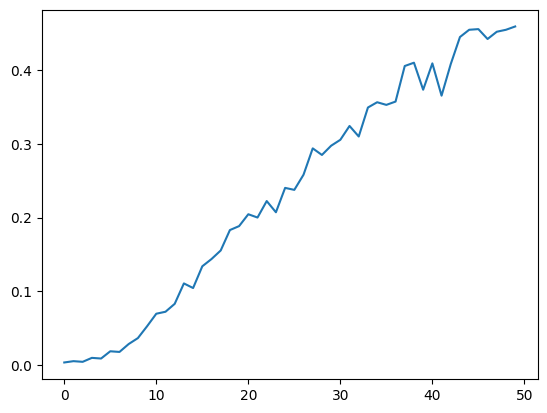

In [ ]:
# Entraînement du modèle
history = model.fit(
    train_generator,
    # validation_data=validation_generator,
    epochs=epochs
)

# Courbe de précision
plt.plot(history.history['accuracy'], label='Précision Entraînement')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.show()

# Courbe de perte
plt.plot(history.history['loss'], label='Perte Entraînement')
plt.plot(history.history['val_loss'], label='Perte Validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.show()

# Fonction pour capturer une image
def capture_image():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Erreur : impossible d'accéder à la caméra")
        return None
    
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.title("Image Capturée")
        plt.axis('off')
        plt.show()
        
        img = cv2.resize(frame, (128, 128))
        img = img_to_array(img) / 255.0
        img = np.expand_dims(img, axis=0)
        return frame, img
    else:
        print("Erreur lors de la capture de l'image")
        return None, None


In [17]:
# Sauvegarde du modèle
model.save("modelfinal.h5")

Found 1116 images belonging to 460 classes.


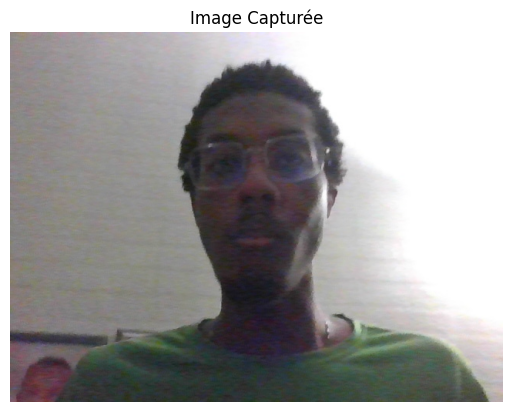

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Top 5 joueurs ressemblants :
Jonquel Jones: 49.57%
Vasilije Micić: 7.28%
Jean Patry: 2.10%
Flávio Gualberto: 1.66%
Conor McGregor: 1.65%


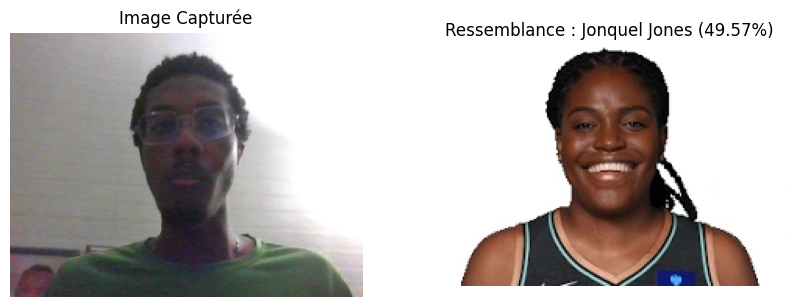

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

# Fonction de prédiction de ressemblance
def predict_ressemblance(model, image, frame, data_dir, train_generator):
    # Prédiction du modèle
    predictions = model.predict(image)[0]
    class_names = list(train_generator.class_indices.keys())

    # Trier les probabilités par ordre décroissant
    sorted_predictions = sorted(zip(class_names, predictions), key=lambda x: x[1], reverse=True)
    top_5_predictions = sorted_predictions[:5]

    print("Top 5 joueurs ressemblants :")
    for class_name, prob in top_5_predictions:
        print(f"{class_name}: {prob * 100:.2f}%")

    # Joueur prédit (le plus probable)
    predicted_player = top_5_predictions[0][0]
    player_path = os.path.join(data_dir, predicted_player)

    if not os.path.exists(player_path):
        print(f"Erreur : dossier du joueur {predicted_player} introuvable.")
        return

    # Charger une image du joueur prédit pour l'afficher
    player_images = [img for img in os.listdir(player_path) if img.endswith(('.jpg', '.png', '.jpeg'))]
    
    if not player_images:
        print(f"Aucune image trouvée pour le joueur {predicted_player}.")
        return

    best_match_image_path = os.path.join(player_path, player_images[0])
    best_match_image = cv2.imread(best_match_image_path)

    if best_match_image is None:
        print(f"Erreur de chargement de l'image du joueur : {best_match_image_path}")
        return

    # Affichage de l'image capturée et de la meilleure correspondance
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title("Image Capturée")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(best_match_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Ressemblance : {predicted_player} ({top_5_predictions[0][1] * 100:.2f}%)")
    plt.axis('off')
    plt.show()

# Capture d'image depuis la webcam
def capture_image():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Erreur : impossible d'accéder à la caméra")
        return None, None

    ret, frame = cap.read()
    cap.release()

    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.title("Image Capturée")
        plt.axis('off')
        plt.show()

        img = cv2.resize(frame, (128, 128))
        img = img_to_array(img) / 255.0
        img = np.expand_dims(img, axis=0)
        return frame, img
    else:
        print("Erreur lors de la capture de l'image")
        return None, None

# Charger le modèle entraîné
model = tf.keras.models.load_model('modelfinal.h5')

# Définition du répertoire des données d'entraînement
data_dir = "Players_merged1"

# Générateur d'images pour accéder aux classes
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Capture d'une image et prédiction
frame, image = capture_image()

if image is not None:
    predict_ressemblance(model, image, frame, data_dir, train_generator)


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
import os
from PIL import Image
import collections

# --- Étape 1 : Conversion des images PNG en RGB ---
def convert_images_to_rgb(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".png"):  # Vérifie si c'est un PNG
                img_path = os.path.join(root, file)
                img = Image.open(img_path)

                if img.mode == "P":  # Mode Palette avec transparence
                    img = img.convert("RGBA")

                if img.mode == "RGBA":  # Gérer la transparence
                    new_img = Image.new("RGB", img.size, (255, 255, 255))  # Fond blanc
                    new_img.paste(img, mask=img.split()[3])  # Appliquer le masque alpha
                    new_img.save(img_path)
                else:
                    img.convert("RGB").save(img_path)  # Convertir en RGB si nécessaire

# Appliquer la conversion avant l'entraînement
data_dir = "Players_merged"
convert_images_to_rgb(data_dir)

# --- Étape 2 : Paramètres globaux ---
image_size = (128, 128)
batch_size = 32
epochs = 50

# --- Étape 3 : Vérification des classes ---
def check_class_distribution(generator):
    class_counts = collections.Counter(generator.classes)
    print("Distribution des images par classe:", class_counts)

# --- Étape 4 : Préparation des données avec augmentation forte ---
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

# Générateurs d'images
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

check_class_distribution(train_generator)

# --- Étape 5 : Modèle basé sur MobileNetV2 ---
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- Étape 6 : Entraînement du modèle ---
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10  # On entraîne d'abord 10 epochs avec MobileNetV2 figé
)

# --- Étape 7 : Défiger certaines couches et réduire le learning rate ---
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Gèle les premières couches, entraîne les 30 dernières
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40  # Continue l'entraînement avec le modèle partiellement dégelé
)

# --- Étape 8 : Affichage des courbes d'entraînement ---
def plot_training(history):
    plt.plot(history.history['accuracy'], label='Précision Entraînement')
    plt.plot(history.history['val_accuracy'], label='Précision Validation')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Perte Entraînement')
    plt.plot(history.history['val_loss'], label='Perte Validation')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()
    plt.show()

plot_training(history)
plot_training(history_finetune)

# --- Étape 9 : Capture d'image pour tester le modèle ---
def capture_image():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Erreur : impossible d'accéder à la caméra")
        return None
    
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.title("Image Capturée")
        plt.axis('off')
        plt.show()
        
        img = cv2.resize(frame, (128, 128))
        img = img_to_array(img) / 255.0
        img = np.expand_dims(img, axis=0)
        return frame, img
    else:
        print("Erreur lors de la capture de l'image")
        return None, None

# --- Étape 10 : Sauvegarde du modèle ---
model.save("model_merged.h5")
print("Modèle sauvegardé dans model_merged.h5")


Found 7914 images belonging to 424 classes.
Found 1696 images belonging to 424 classes.
Distribution des images par classe: Counter({np.int32(1): 20, np.int32(6): 20, np.int32(7): 20, np.int32(8): 20, np.int32(10): 20, np.int32(12): 20, np.int32(13): 20, np.int32(14): 20, np.int32(16): 20, np.int32(17): 20, np.int32(21): 20, np.int32(24): 20, np.int32(28): 20, np.int32(29): 20, np.int32(31): 20, np.int32(32): 20, np.int32(37): 20, np.int32(39): 20, np.int32(49): 20, np.int32(50): 20, np.int32(51): 20, np.int32(52): 20, np.int32(53): 20, np.int32(54): 20, np.int32(60): 20, np.int32(63): 20, np.int32(68): 20, np.int32(69): 20, np.int32(70): 20, np.int32(72): 20, np.int32(81): 20, np.int32(82): 20, np.int32(85): 20, np.int32(86): 20, np.int32(91): 20, np.int32(92): 20, np.int32(98): 20, np.int32(100): 20, np.int32(108): 20, np.int32(109): 20, np.int32(110): 20, np.int32(111): 20, np.int32(116): 20, np.int32(0): 19, np.int32(2): 19, np.int32(3): 19, np.int32(4): 19, np.int32(5): 19, np.int

KeyboardInterrupt: 

In [ ]:
import os
import shutil
from itertools import cycle

# Définition des chemins
merged_dir = "Players_merged"
football_dir = os.path.join(merged_dir, "football")

# Vérifier si le dossier football existe
if not os.path.exists(football_dir):
    print("Le dossier 'football' n'existe pas.")
    exit()

# Lister tous les dossiers joueurs sauf "football"
player_dirs = [d for d in os.listdir(merged_dir) if os.path.isdir(os.path.join(merged_dir, d)) and d != "football"]

# Lister toutes les images dans "football"
football_images = [f for f in os.listdir(football_dir) if os.path.isfile(os.path.join(football_dir, f))]

# Vérifier s'il y a des dossiers joueurs pour dispatcher les images
if not player_dirs:
    print("Aucun dossier joueur trouvé dans 'Players_merged'.")
    exit()

# Répartir les images en boucle sur les dossiers joueurs
player_cycle = cycle(player_dirs)  # Création d'un cycle infini des dossiers joueurs

for img in football_images:
    player = next(player_cycle)  # Récupérer le dossier joueur suivant
    src_path = os.path.join(football_dir, img)
    dest_path = os.path.join(merged_dir, player, img)  # Déplacer sans changer le nom
    shutil.move(src_path, dest_path)  # Déplacer le fichier

print("Distribution des images terminée !")


Le dossier 'football' n'existe pas.


FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'Players_merged'

: 

In [6]:
import os
import shutil

# Dossier source (Players_merged)
source_dir = "Players_merged"
# Dossier de destination où vous allez organiser les classes
destination_dir = "Players_organized"

# Créez les 3 dossiers pour les classes
os.makedirs(os.path.join(destination_dir, "classe 1"), exist_ok=True)
os.makedirs(os.path.join(destination_dir, "classe 2"), exist_ok=True)
os.makedirs(os.path.join(destination_dir, "classe 3"), exist_ok=True)

# Compteur pour cycler entre les 3 classes
class_counter = 0

# Parcourez chaque sous-dossier dans Players_merged
for subfolder in os.listdir(source_dir):
    subfolder_path = os.path.join(source_dir, subfolder)

    if os.path.isdir(subfolder_path):
        # Récupérer les images du sous-dossier
        images = [f for f in os.listdir(subfolder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        # Répartir les images dans les 3 classes de manière cyclique
        for image in images:
            image_path = os.path.join(subfolder_path, image)
            
            # Déterminer la classe en fonction du compteur
            if class_counter % 3 == 0:
                target_class = "classe 1"
            elif class_counter % 3 == 1:
                target_class = "classe 2"
            else:
                target_class = "classe 3"
            
            # Créez le chemin de destination
            target_path = os.path.join(destination_dir, target_class, image)
            
            # Déplacer l'image dans le dossier cible
            shutil.copy(image_path, target_path)  # Utilisez shutil.move si vous voulez déplacer au lieu de copier

            # Incrémenter le compteur de classe pour cycler entre les 3 classes
            class_counter += 1

print("Réorganisation terminée.")


Réorganisation terminée.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import collections

# --- Étape 2 : Paramètres globaux ---
image_size = (128, 128)  # Réduction de la taille des images
batch_size = 32
epochs_initial = 10
epochs_finetune = 40

# --- Étape 3 : Préparation des données avec augmentation ---
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,  # Moins de rotation
    width_shift_range=0.1,  # Moins de décalage horizontal
    height_shift_range=0.1,  # Moins de décalage vertical
    shear_range=0.1,  # Moins de cisaillement
    zoom_range=0.1,  # Moins de zoom
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],  # Plage de luminosité plus petite
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

def check_class_distribution(generator):
    class_counts = collections.Counter(generator.classes)
    print("Distribution des images par classe:", class_counts)

check_class_distribution(train_generator)

# --- Étape 4 : Création du modèle MobileNetV2 ---
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Dé-geler certaines couches dès le début

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# --- Étape 5 : Compilation et entraînement initial ---
model.compile(optimizer=Adam(learning_rate=1e-4),  # Taux d'apprentissage plus faible
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs_initial
)

# --- Étape 6 : Défiger certaines couches et affiner le modèle ---
base_model.trainable = True
for layer in base_model.layers[:20]:  # Geler moins de couches (par exemple, les 20 premières)
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),  # Réduire encore le taux d'apprentissage
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs_finetune
)

# --- Étape 7 : Affichage des courbes d'entraînement ---
def plot_training(history):
    plt.plot(history.history['accuracy'], label='Précision Entraînement')
    plt.plot(history.history['val_accuracy'], label='Précision Validation')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Perte Entraînement')
    plt.plot(history.history['val_loss'], label='Perte Validation')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()
    plt.show()

plot_training(history)
plot_training(history_finetune)

# --- Étape 8 : Sauvegarde du modèle ---
model.save("model_organized.h5")
print("Modèle sauvegardé sous model_organized.h5")


Found 7690 images belonging to 3 classes.
Found 1920 images belonging to 3 classes.
Distribution des images par classe: Counter({np.int32(0): 2564, np.int32(1): 2563, np.int32(2): 2563})


c:\Users\yvenl\OneDrive\Bureau\B3Data&IA\Maths\mon_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


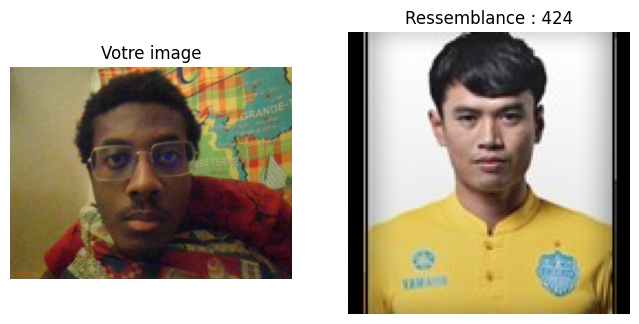

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
import json

# Charger le modèle entraîné
model = tf.keras.models.load_model("model_organized.h5")

# Charger la correspondance des classes avec les images de référence
class_map_path = "class_image_map.json"  # Fichier JSON contenant les chemins des images de référence
with open(class_map_path, "r") as f:
    class_image_map = json.load(f)

# Capture d'une image via la webcam
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

if not ret:
    print("Erreur : Impossible de capturer l'image")
    exit()

# Prétraitement de l'image
image_size = (128, 128)
image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, image_size)
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

# Prédiction avec le modèle
predictions = model.predict(image)
predicted_class = np.argmax(predictions)
predicted_label = str(predicted_class)  # Convertir en string pour correspondre à la clé JSON

# Charger l'image correspondante à la classe prédite
if predicted_label in class_image_map:
    predicted_image_path = class_image_map[predicted_label]
    predicted_image = load_img(predicted_image_path, target_size=image_size)
else:
    print("Erreur : Aucune image de référence trouvée pour cette classe.")
    exit()

# Affichage des images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
ax[0].set_title("Votre image")
ax[0].axis("off")

ax[1].imshow(predicted_image)
ax[1].set_title(f"Ressemblance : {predicted_label}")
ax[1].axis("off")

plt.show()
